In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse, weighted_rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Load files with test and train splitting

In [4]:
def read_data_path(file):
    list_of_paths = []
    with open(file) as json_file:
        data = json.load(json_file)
        for item in data.items():
            list_of_paths += [item[1]]
    return list_of_paths

In [5]:
train_img_list = read_data_path('/home/user/data/train_data.txt')
test_img_list = read_data_path('/home/user/data/test_data.txt')
val_img_list = read_data_path('/home/user/data/val_data.txt')

In [6]:
train_img_list[0]

'/home/user/data/krasnoborsk/world_view/4/1_0'

## Specify the task

In [7]:
batch_size=20 
num_channels=5

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = False             # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = True      # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.arctic_dem = True
generator.arctic_stat = {'min':125, 'max':250}

generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.clip_value = 30.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif', 'channel_3.tif']

##############################################
# Model saving names
##############################################

model_name = 'rgb_nir_model'
save_dir = '/home/user/data/Height_model_paper/'

In [17]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [7]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

save_file = 'regr_rgb_pan_nir_wv_arctic.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

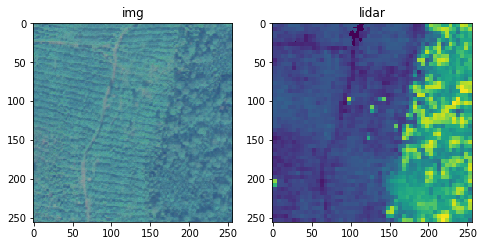

In [18]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Text(0.5,1,'lidar')

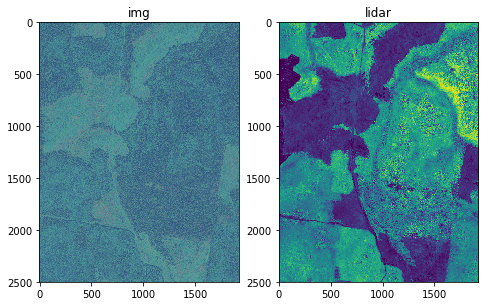

In [22]:
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[3])
generator.full_img = False  

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set weights for height classes

In [17]:
values=(0.5 /(distribution / np.max(distribution))[1:30]).clip(1, 4)

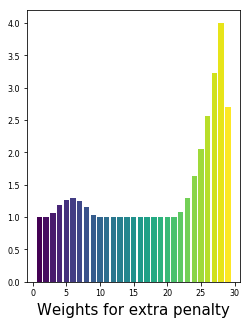

In [45]:
names = np.array([i for i in range(1, 30)])
#values = (distribution / np.sum(distribution))[1:30]

from matplotlib import cm
viridis = cm.get_cmap('viridis', 29)

plt.figure(figsize=(13, 5))

plt.subplot(131)
plt.bar(names, values, color=viridis(range(29)))
#plt.suptitle('Categorical Plotting')
plt.xlabel('Weights for extra penalty', fontsize=15)
plt.show()

## Set model

In [19]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  weighted_rmse(values)
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  str(input_shape[-1]) + ' input channels.')


In [21]:
# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [22]:
history=model.fit_generator(generator.train_gen(),epochs=23, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/23
200/200 [==============================] - 196s 979ms/step - loss: 0.2876 - loss_1: 0.2876 - val_loss: 0.6906 - val_loss_1: 0.6906

Epoch 00001: val_loss improved from inf to 0.69058, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00001: val_loss improved from inf to 0.69058, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5
Epoch 2/23
200/200 [==============================] - 147s 737ms/step - loss: 0.2543 - loss_1: 0.2543 - val_loss: 0.2635 - val_loss_1: 0.2635

Epoch 00002: val_loss improved from 0.69058 to 0.26345, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00002: val_loss improved from 0.69058 to 0.26345, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5
Epoc

Epoch 23/23
200/200 [==============================] - 145s 727ms/step - loss: 0.1645 - loss_1: 0.1645 - val_loss: 0.1584 - val_loss_1: 0.1584

Epoch 00023: val_loss improved from 0.15880 to 0.15841, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.h5

Epoch 00023: val_loss improved from 0.15880 to 0.15841, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_nir_wv_arctic_weighted.hdf5


In [47]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [50]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Prediction for crops

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


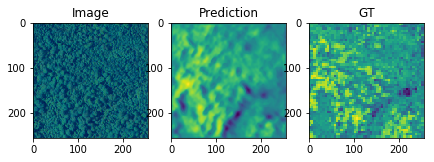

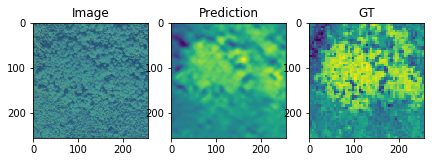

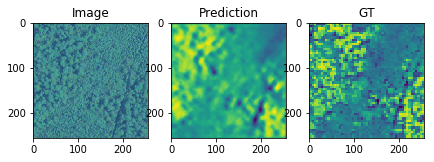

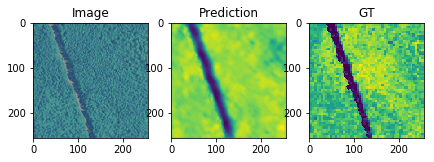

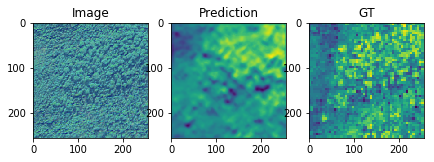

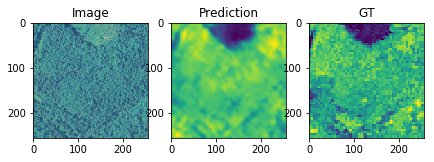

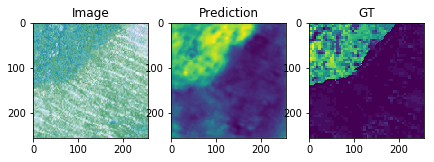

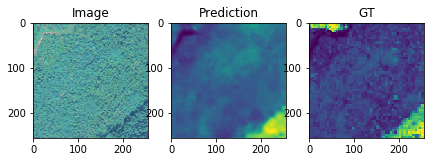

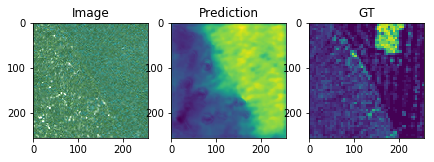

In [56]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

for num in range(1, 10):
    fig = plt.figure(figsize=(7, 7))
    
    a = fig.add_subplot(1, 3, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num,:,:,:3])
    
    cl=0
    a = fig.add_subplot(1, 3, 2)
    a.set_title('Prediction')
    imgplot = plt.imshow(pred[num, :, :,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 3, 3)
    a.set_title('GT')
    imgplot = plt.imshow(mask[num, :, :,0])

## Evaluation

In [25]:
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[2])

Text(0.5,1,'lidar')

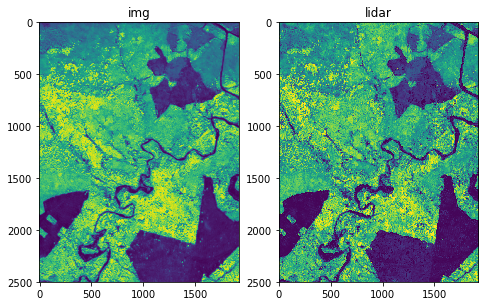

In [26]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('prediction')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [281]:
generator.full_img=True
img, _ = generator.get_img_mask_array(val_img_list[2])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0e04d8d940>)

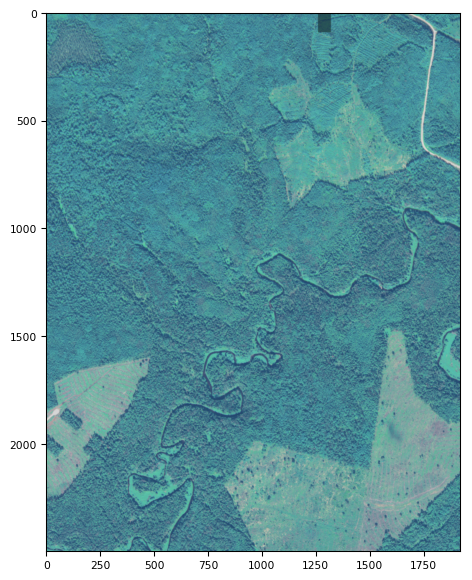

In [287]:
tiff.imshow(img[:,:,:3])

In [51]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.423  mae:  2.662  r2:  0.599  mbe:  0.3571494636184732
1 rmse:  2.703  mae:  1.959  r2:  0.78  mbe:  0.23154950571944938
2 rmse:  3.789  mae:  2.715  r2:  0.798  mbe:  0.20666881268548198
3 rmse:  3.514  mae:  2.526  r2:  0.603  mbe:  -0.7003137241232229
~~~~~~~~~~~~~~~~
Average RMSE:  3.607
Average MAE:  2.466
Average R2:  0.695
Average mean bias:  0.024


In [ ]:
num_cl = 4
generator.augm = False
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

In [36]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.79337054 0.50806577 0.83573816 0.59572692]
0.6832253470011631


## Save prediction

In [256]:
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    save_dist = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/' + img_path.split('/')[-1]
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist=save_dist + '_pred.tif', \
          info_img=img_path + '_channel_0.tif', crs=4326)
    #tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')

2045 1248 (2498, 1918)
2045 1248 (2498, 1918)
2045 1248 (2498, 1918)
2045 1248 (2498, 1918)


tmp = tiff.imread('../images/tmp.tif')

In [ ]:
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img=img_path + '_channel_0.tif', crs=4326)
    tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')
    break